In [481]:
#import libraries and setup sql cursor
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
import requests 
import matplotlib.pyplot as plt

conn = sqlite3.connect('data/movies.db')
cur = conn.cursor()

In [482]:
#get rotten tomatoe data
rt_movies = pd.DataFrame(cur.execute("SELECT movie_title, genres FROM rotten_tomatoes_movies").fetchall())
rt_movies.columns = [i[0] for i in cur.description]

In [483]:
#get bom movie data
bom_movie_gross = pd.DataFrame(cur.execute("SELECT foreign_gross, domestic_gross, title from bom_movie_gross").fetchall())
bom_movie_gross.columns = [i[0] for i in cur.description]
bom_movie_gross = bom_movie_gross[bom_movie_gross["foreign_gross"].notna()]

In [484]:
#create merged dataframe of rotten tomatoe and bom movies
bom_gross_rt_genre = rt_movies.join(bom_movie_gross, how="inner")

In [485]:
bom_gross_rt_genre.dropna(inplace=True)

In [486]:
not_list_format =  bom_gross_rt_genre

In [487]:
not_list_format.head()

,movie_title,genres,foreign_gross,domestic_gross,title
0,Percy Jackson & the Olympians: The Lightning T...,"Action & Adventure, Comedy, Drama, Science Fic...",652000000,415000000.0,Toy Story 3
1,Please Give,Comedy,691300000,334200000.0,Alice in Wonderland (2010)
2,10,"Comedy, Romance",664300000,296000000.0,Harry Potter and the Deathly Hallows Part 1
3,12 Angry Men (Twelve Angry Men),"Classics, Drama",535700000,292600000.0,Inception
4,"20,000 Leagues Under The Sea","Action & Adventure, Drama, Kids & Family",513900000,238700000.0,Shrek Forever After


In [488]:
#group by genres to show mean of domestic gross by get
#bom_gross_rt_genre.groupby(["genres"])["domestic_gross"].mean()

In [489]:
#reformat genres data go make it a list of items
genres = bom_gross_rt_genre["genres"].str.replace("&", ",")
genres = bom_gross_rt_genre["genres"].str.split(',')
#bom_gross_rt_genre["genres"] = bom_gross_rt_genre["genres"].str.strip(" ")

In [490]:
#sc
genres

0       [Action & Adventure,  Comedy,  Drama,  Science...
1                                                [Comedy]
2                                      [Comedy,  Romance]
3                                      [Classics,  Drama]
4            [Action & Adventure,  Drama,  Kids & Family]
                              ...                        
3275                [Comedy,  Drama,  Mystery & Suspense]
3286                                             [Comedy]
3309                [Comedy,  Drama,  Mystery & Suspense]
3342                                   [Comedy,  Romance]
3353                                     [Comedy,  Drama]
Name: genres, Length: 2005, dtype: object

In [491]:
#make list of genres so I can get unique ones
all_genres = []
for item in genres:
    if item != None:
        for genre in item:
            all_genres.append(genre)
unique_genres = set(all_genres)

In [492]:
unique_genres = set([(genre.strip()) for genre in unique_genres])

In [493]:
#sc
unique_genres

{'Action & Adventure',
 'Animation',
 'Anime & Manga',
 'Art House & International',
 'Classics',
 'Comedy',
 'Cult Movies',
 'Documentary',
 'Drama',
 'Faith & Spirituality',
 'Gay & Lesbian',
 'Horror',
 'Kids & Family',
 'Musical & Performing Arts',
 'Mystery & Suspense',
 'Romance',
 'Science Fiction & Fantasy',
 'Special Interest',
 'Sports & Fitness',
 'Television',
 'Western'}

In [494]:
#unique_genres
not_list_format[not_list_format["genres"].str.contains("Action")]

,movie_title,genres,foreign_gross,domestic_gross,title
0,Percy Jackson & the Olympians: The Lightning T...,"Action & Adventure, Comedy, Drama, Science Fic...",652000000,415000000.0,Toy Story 3
4,"20,000 Leagues Under The Sea","Action & Adventure, Drama, Kids & Family",513900000,238700000.0,Shrek Forever After
5,"10,000 B.C.","Action & Adventure, Classics, Drama",398000000,300500000.0,The Twilight Saga: Eclipse
6,The 39 Steps,"Action & Adventure, Classics, Mystery & Suspense",311500000,312400000.0,Iron Man 2
18,The Adventures of Mark Twain,"Action & Adventure, Animation, Kids & Family",216400000,105300000.0,Robin Hood
...,...,...,...,...,...
3250,Battle: Los Angeles,"Action & Adventure, Science Fiction & Fantasy",530000,4300000.0,Blindspotting
3255,Battle For Terra,"Action & Adventure, Animation, Science Fiction...",3900000,330000.0,Hichki
3257,Battle in Seattle,"Action & Adventure, Drama",2500000,1400000.0,Don't Worry He Won't Get Far on Foot
3258,Battle of Britain,"Action & Adventure, Classics, Drama",2200000,1600000.0,A Private War


In [495]:
not_list_format["foreign_gross"] = not_list_format["foreign_gross"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

In [496]:
d_gross = []
f_gross = []

for genre in unique_genres:
    frame = not_list_format[not_list_format["genres"].str.contains(genre)]
    mean_d_gross = round(frame["domestic_gross"].mean(), 1)
    mean_f_gross = round(frame["foreign_gross"].mean(), 1)
    d_gross.append(mean_d_gross)
    f_gross.append(mean_f_gross)

In [497]:

# for item in frame["foreign_gross"]:
#     if isinstance(item, str):
#         print("str")
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 2 to 3342
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_title     262 non-null    object 
 1   genres          262 non-null    object 
 2   foreign_gross   260 non-null    float64
 3   domestic_gross  262 non-null    float64
 4   title           262 non-null    object 
dtypes: float64(2), object(3)
memory usage: 12.3+ KB


In [498]:
f_gross

[66287178.7,
 32589066.7,
 58714905.7,
 93350253.8,
 74008937.8,
 76381528.5,
 61694001.2,
 74761154.7,
 83113305.5,
 73940830.6,
 84770370.3,
 8000000.0,
 61579600.0,
 76475333.3,
 149133333.3,
 76575381.1,
 91274789.4,
 85556063.0,
 85257633.5,
 49960843.2,
 70949219.6]

In [499]:
#turn gross lists and unique genres into dictionary in one variable
genre_grossing_dict = {"genre": list(unique_genres), "domestic_gross": d_gross, "foreign_gross": f_gross}

In [500]:
#genre_grossing = pd.DataFrame(genre_averages, columns =['genre', 'domestic_gross', 'foreign_gross'])
genre_grossing = pd.DataFrame(genre_grossing_dict)
# genre_grossing["genre"] = genre_averages.keys()
# genre_grossing["genre"] = [item[0] for item in genre_grossing.values()]

In [501]:
#set genres as index so I can drop stuff based on it
#genre_grossing.set_index("genre")

In [502]:
genre_grossing = genre_grossing[genre_grossing["genre"] != 'Cult Movies']
genre_grossing = genre_grossing[genre_grossing["genre"] != 'Television']
genre_grossing = genre_grossing[genre_grossing["genre"] != 'Classics']
genre_grossing = genre_grossing[genre_grossing["genre"] != 'Art House & International']

In [503]:
genre_grossing.sort_values("domestic_gross", ascending=False, inplace=True)

In [505]:
genre_grossing

,genre,domestic_gross,foreign_gross
18,Art House & International,55376266.7,85257633.5
20,Romance,53211187.0,70949219.6
17,Action & Adventure,52581324.5,85556063.0
3,Musical & Performing Arts,51692970.9,93350253.8
16,Science Fiction & Fantasy,51196230.7,91274789.4
5,Comedy,49776359.0,76381528.5
12,Sports & Fitness,47383570.6,61579600.0
7,Drama,45646750.6,74761154.7
4,Horror,44980399.1,74008937.8
9,Mystery & Suspense,44639995.1,73940830.6


Text(0, 0.5, 'Genre')

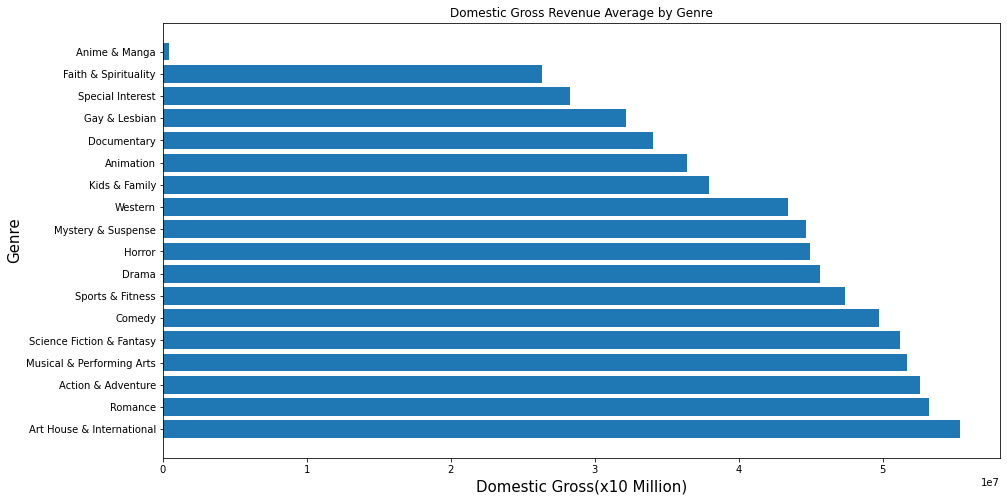

In [508]:
fig, ax = plt.subplots(figsize= (15, 8))
ax.barh(genre_grossing["genre"], genre_grossing["domestic_gross"])
ax.set_title("Domestic Gross Revenue Average by Genre")
ax.set_xlabel("Domestic Gross(x10 Million)",fontsize=15)
ax.set_ylabel("Genre",fontsize=15)

AttributeError: 'str' object has no attribute 'get_height'